In [1]:
import pandas as pd
import numpy as np

## Get the Data

Note: before completing this step, the following steps should be run:
* ChicagoPDData notebook
* make all in main directory
* make all in AoT_data/

In [ ]:
# a_dir = 'AoT_data/'
# node_loc_list = pd.read_csv(a_dir+'node_loc_list.csv',index_col=0)
# feature_list = pd.read_csv (a_dir+'feature_list.csv')
# full_data= pd.read_csv(a_dir+'fixed_data.csv')

In [2]:
def create_crime_dict():
    crime_dict = {}
    with open('final_dat.csv','r') as file:
        for line in file:
            curr_line=line.strip().split(',')
            if curr_line[0] not in crime_dict.keys():
                crime_dict[curr_line[0]]={'coords':[]}
            crime_dict[curr_line[0]]['coords'].append((float(curr_line[2]),float(curr_line[1])))
    return crime_dict

In [ ]:
#crime_dict=create_crime_dict()

In [ ]:
# full_data =full_data.loc[full_data['parameter']!='id']

In [ ]:
# full_data.shape

In [ ]:
# full_data.head()

In [ ]:
# full_data.values.tolist()

In [ ]:
# len(crime_data.index.unique())

In [ ]:
# len(crime_data)

In [ ]:
# node_loc_list.head()

# Transform the Data

There is a very large amount of data to handle here, so dictionaries are used for speed

In [ ]:
#node_dict=node_loc_list.to_dict('index')
#full_list=full_data.values.tolist()

The function below takes a list version of the full data (obtained from full_data.values.tolist()) and converts it to a dictionary

In [3]:
def get_full_dict(full_list,node_dict):
    full_dict={}
    for index,row in enumerate(full_list):
        timestamp=row[0][0:13]
        node_id=row[1]
        full_id = str(timestamp)+'_'+str(node_id)
        feature_name = str(row[3])+'_'+str(row[4])
        value=row[5]
        node_lat=node_dict[node_id]['lat']
        node_lon=node_dict[node_id]['lon']
        if not full_id in full_dict.keys():
            full_dict[full_id]={}
        full_dict[full_id][feature_name]=value
        full_dict[full_id]['timestamp']=timestamp
        full_dict[full_id]['node_id']=node_id
        full_dict[full_id]['latitude']=node_lat
        full_dict[full_id]['longitude']=node_lon
    return full_dict

In [ ]:
# get_full_dict(full)

In [ ]:
# len(full_dict)

In [21]:
def add_labels(full_dict,crime_dict,max_dist=2):
    for id in full_dict.keys():
        label=0
        timestamp=full_dict[id]['timestamp']
        node_lat=full_dict[id]['latitude']
        node_lon=full_dict[id]['longitude']
        if timestamp in crime_dict.keys():
            crime_coords=crime_dict[timestamp]['coords']
            label = crime_occurrence_check((node_lat,node_lon),crime_coords,max_dist)
        full_dict[id]['label']=label
    return full_dict

In [ ]:
#next(iter(full_dict.values()))

Note, the function below is not mine, it is pulled from [https://stackoverflow.com/questions/15736995/how-can-i-quickly-estimate-the-distance-between-two-latitude-longitude-points]

In [5]:
from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

In [6]:
def crime_occurrence_check(node_coords,crime_coods_list,max_dist=2):
    crime_occurred=0
    for crime_coord in crime_coods_list:
        if haversine(node_coords[1],node_coords[0],crime_coord[1],crime_coord[0]) < max_dist:
            crime_occurred=1
            return crime_occurred
    return crime_occurred

In [ ]:
# full_data = pd.DataFrame.from_dict(full_dict,orient='index')

To decide an appropriate value for max_dist, let's look at the average minimum distance between the current nodes. We choose this statistic, as it means on average, the closest node is that far away. Thus, by assigning crimes only if they are less than this distance, we will on average only assign the crime to the closest node. 

In [19]:
import statistics
def find_avg_node_dist(node_loc_list):
    distance_avgs=[]
    for index,row in node_loc_list.iterrows():
        base_lat=row[0]
        base_lon=row[1]
        distances=[]
        for index2,row2 in node_loc_list.iterrows():
            if index != index2:
                distances.append(haversine(base_lon,base_lat,row2[1],row2[0]))  
        distance_avgs.append(min([x for x in distances if x>0]))
    return statistics.mean(distance_avgs)

In [20]:
import math
a_dir = 'AoT_data/'
node_loc_list = pd.read_csv(a_dir+'node_loc_list.csv',index_col=0)
max_dist = math.ceil(find_avg_node_dist(node_loc_list))
print(max_dist,"km")

2 km


In [22]:
def get_full_set():
    a_dir = 'AoT_data/'
    node_loc_list = pd.read_csv(a_dir+'node_loc_list.csv',index_col=0)
    max_dist = math.ceil(find_avg_node_dist(node_loc_list))
    feature_list = pd.read_csv (a_dir+'feature_list.csv')
    full_data= pd.read_csv(a_dir+'fixed_data.csv')
    full_data =full_data.loc[full_data['parameter']!='id']
    full_list=full_data.values.tolist()
    node_dict=node_loc_list.to_dict('index')
    full_dict=get_full_dict(full_list,node_dict)
    crime_dict=create_crime_dict()
    full_dict=add_labels(full_dict,crime_dict,max_dist)
    labeled_data = pd.DataFrame.from_dict(full_dict,orient='index')
    return labeled_data

In [11]:
# NOTE: This cell takes around 2 minutes to run but does all of the data preprocessing
import time
start=time.time()
labeled_data=get_full_set()
print("--- %s seconds ---" % (time.time() - start))

--- 130.01387310028076 seconds ---


In [15]:
print(labeled_data.shape)
labeled_data.head()

(546257, 145)


,bmp180_temperature,timestamp,htu21d_temperature,tsl250rd_intensity,longitude,tmp112_temperature,ml8511_intensity,label,pr103j2_temperature,tsl260rd_intensity,...,microphone_octave_6_intensity,microphone_octave_7_intensity,microphone_octave_5_intensity,microphone_octave_1_intensity,hist_g,microphone_octave_9_intensity,net_usb_tx,avg_b,microphone_octave_total_intensity,hist_r
2017/03/28 17_001e0610ba46,28.695,2017/03/28 17,27.715,1.639,-87.627678,28.270,43.646,1,28.159,4.198,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017/03/28 19_001e0610ba46,29.483,2017/03/28 19,28.431,1.088,-87.627678,29.055,42.939,1,28.889,1.294,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017/03/28 20_001e0610ba46,31.011,2017/03/28 20,29.749,0.863,-87.627678,30.592,41.709,1,30.430,1.113,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017/03/28 21_001e0610ba46,31.211,2017/03/28 21,29.929,1.250,-87.627678,30.796,40.990,0,30.614,1.834,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017/03/28 22_001e0610ba46,31.422,2017/03/28 22,30.135,3.289,-87.627678,30.986,40.849,1,30.834,10.466,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [102]:
labeled_data =labeled_data.fillna(0)

In [106]:
print(len(labeled_data[labeled_data['label']==0]))
len(labeled_data[labeled_data['label']==1])

409665


136592

## Split out the train, dev, and test set

At this point, we want to split the data into training, development, and test sets

In [69]:
from sklearn.model_selection import train_test_split

We want our X to be all values except the label,timestamp, and node_id as these should be the only non_numerical features

In [70]:
All_X = labeled_data.drop(['label','timestamp','node_id'],axis=1)
All_y = labeled_data['label']

In [71]:
All_X.head()

,bmp180_temperature,htu21d_temperature,tsl250rd_intensity,longitude,tmp112_temperature,ml8511_intensity,pr103j2_temperature,tsl260rd_intensity,hih6130_temperature,bmp180_pressure,...,microphone_octave_6_intensity,microphone_octave_7_intensity,microphone_octave_5_intensity,microphone_octave_1_intensity,hist_g,microphone_octave_9_intensity,net_usb_tx,avg_b,microphone_octave_total_intensity,hist_r
2017/03/28 17_001e0610ba46,28.695,27.715,1.639,-87.627678,28.270,43.646,28.159,4.198,30.867,996.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017/03/28 19_001e0610ba46,29.483,28.431,1.088,-87.627678,29.055,42.939,28.889,1.294,33.923,996.390,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017/03/28 20_001e0610ba46,31.011,29.749,0.863,-87.627678,30.592,41.709,30.430,1.113,41.583,996.742,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017/03/28 21_001e0610ba46,31.211,29.929,1.250,-87.627678,30.796,40.990,30.614,1.834,46.087,996.900,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017/03/28 22_001e0610ba46,31.422,30.135,3.289,-87.627678,30.986,40.849,30.834,10.466,46.942,997.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
All_y.head()

2017/03/28 17_001e0610ba46    1
2017/03/28 19_001e0610ba46    1
2017/03/28 20_001e0610ba46    1
2017/03/28 21_001e0610ba46    0
2017/03/28 22_001e0610ba46    1
Name: label, dtype: int64

In [73]:
X,X_test,y,y_test=train_test_split(All_X,All_y,test_size=0.2,random_state=42)

We will now never ever look at X_test and y_test, and will leave them until the very end of the process

We do also want a development set, so we split again

In [74]:
X_train,X_dev,y_train,y_dev=train_test_split(X,y,test_size=0.1,random_state=42)

In [75]:
print('X_train: ',X_train.shape,'Y_train: ',y_train.shape)
print('X_dev: ',X_dev.shape, 'Y_dev: ',y_dev.shape)

X_train:  (393304, 142) Y_train:  (393304,)
X_dev:  (43701, 142) Y_dev:  (43701,)


Perfect! Now we have something we can work with!

## Scaling the features

In [109]:
from sklearn.preprocessing import StandardScaler
X_train_scaled = StandardScaler().fit_transform(X_train)
X_dev_scaled = StandardScaler().fit_transform(X_dev)

In [114]:
print(len([x for x in y_train if x==1]), len([x for x in y_train if x==0]))

98496 294808


# Trying different algorithms

In [97]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C=1.0,random_state=0, solver='lbfgs',max_iter=1000)
clf.fit(X_train_scaled, y_train)

/home/jyckle/ws/chicago/env/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [120]:
def evaluate_model(clf):
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import recall_score
    from sklearn.metrics import precision_score

    y_train_pred=clf.predict(X_train_scaled)
    y_dev_pred=clf.predict(X_dev_scaled)

    print('train_acc: ', accuracy_score(y_train,y_train_pred),'dev_acc: ', accuracy_score(y_dev,y_dev_pred), '\n',
          'train_rec: ',recall_score(y_train,y_train_pred),'dev_rec: ',recall_score(y_dev,y_dev_pred), '\n',
          'train_pre: ',precision_score(y_train,y_train_pred),'dev_pre: ',precision_score(y_dev,y_dev_pred))  

In [107]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)
clf.fit(X_train_scaled,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [108]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

y_train_pred=clf.predict(X_train_scaled)

print('training accuracy: ', accuracy_score(y_train,y_train_pred), '\n',
      'training recall: ',recall_score(y_train,y_train_pred), '\n',
      'training precision: ',precision_score(y_train,y_train_pred))

y_dev_pred=clf.predict(X_dev_scaled)
print('dev accuracy: ', accuracy_score(y_dev,y_dev_pred), '\n',
      'dev recall: ',recall_score(y_dev,y_dev_pred), '\n',
      'dev precision: ',precision_score(y_dev,y_dev_pred))

training accuracy:  0.7495677643756483 
 training recall:  0.0 
 training precision:  0.0
dev accuracy:  0.7467106015880643 
 dev recall:  0.0 
 dev precision:  0.0


/home/jyckle/ws/chicago/env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jyckle/ws/chicago/env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [128]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0,max_depth=10)
clf.fit(X_train_scaled, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [129]:
evaluate_model(clf)

train_acc:  0.7611287960458069 dev_acc:  0.7460012356696644 
 train_rec:  0.20031270305393112 dev_rec:  0.1897190351431927 
 train_pre:  0.565119010110847 dev_pre:  0.4963365634601749


/home/jyckle/ws/chicago/env/lib/python3.5/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


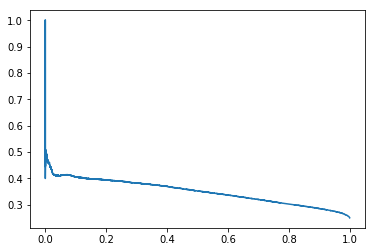

In [132]:
import sklearn.svm
import sklearn.metrics
from matplotlib import pyplot as plt

clf = sklearn.svm.LinearSVC().fit(X_train_scaled, y_train)
decision_values = clf.decision_function(X_train_scaled)

precision, recall, thresholds = sklearn.metrics.precision_recall_curve(y_train, decision_values)

plt.plot(recall, precision)
plt.show()

In [133]:
evaluate_model(clf)

train_acc:  0.7463234546305149 dev_acc:  0.7460698839843481 
 train_rec:  0.030742365172189732 dev_rec:  0.0093956093594724 
 train_pre:  0.41298417894162576 dev_pre:  0.4406779661016949


Try a neural network

In [143]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
keras_model = Sequential()
keras_model.add(Dense(10, input_shape = (len(X_train_scaled[0]),),activation='relu'))
keras_model.add(Dropout(0.2)) 
keras_model.add(Dense(10, activation='relu'))
keras_model.add(Dense(1, activation='sigmoid'))
keras_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [144]:
keras_model.fit(X_train_scaled, y_train, epochs=5,validation_data=(X_dev_scaled,y_dev))

Train on 393304 samples, validate on 43701 samples
Epoch 1/5
393304/393304 [==============================] - 17s 44us/step - loss: 0.5354 - acc: 0.7494 - sparse_categorical_accuracy: 0.7496 - val_loss: 0.5295 - val_acc: 0.7479 - val_sparse_categorical_accuracy: 0.7467
Epoch 2/5
393304/393304 [==============================] - 17s 43us/step - loss: 0.5271 - acc: 0.7501 - sparse_categorical_accuracy: 0.7496 - val_loss: 0.5256 - val_acc: 0.7485 - val_sparse_categorical_accuracy: 0.7467
Epoch 3/5
393304/393304 [==============================] - 17s 43us/step - loss: 0.5230 - acc: 0.7513 - sparse_categorical_accuracy: 0.7496 - val_loss: 0.5231 - val_acc: 0.7488 - val_sparse_categorical_accuracy: 0.7467
Epoch 4/5
393304/393304 [==============================] - 17s 43us/step - loss: 0.5201 - acc: 0.7521 - sparse_categorical_accuracy: 0.7496 - val_loss: 0.5211 - val_acc: 0.7500 - val_sparse_categorical_accuracy: 0.7467
Epoch 5/5
393304/393304 [==============================] - 17s 42us/step 

In [146]:
results =keras_model.predict(X_train_scaled)

In [149]:
max(results)

array([0.6981374], dtype=float32)